In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [86]:
cal_fire_data = pd.read_csv("Housing_Data_Cleaned_03052025.csv")
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

In [87]:
cal_fire_data = pd.get_dummies(cal_fire_data, columns=cal_fire_data.select_dtypes('object').columns)
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 59 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Assessed Improved Value (parcel)                                    42789 non-null  float64
 1   Latitude                                                            42789 non-null  float64
 2   Longitude                                                           42789 non-null  float64
 3   Age                                                                 42789 non-null  float64
 4   Destroyed                                                           42789 non-null  int64  
 5   * Structure Type_Church                                             42789 non-null  bool   
 6   * Structure Type_Commercial Building Multi Story                    42789 non-null  bool   
 7   * Structure T

In [88]:
from sklearn.model_selection import train_test_split
fire_train, fire_test = train_test_split(cal_fire_data, test_size=0.2, shuffle=True, random_state=216, stratify=cal_fire_data['Destroyed'])
fire_train['Destroyed'].value_counts(normalize=True)


Destroyed
0    0.597616
1    0.402384
Name: proportion, dtype: float64

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector


In [90]:
lr = LogisticRegression(penalty=None, max_iter=1000)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)
sfs = SequentialFeatureSelector(estimator=lr, cv=kfold, tol=0.0001)
sfs.fit(fire_train.drop(columns='Destroyed'), fire_train.Destroyed)
features = fire_train.drop(columns='Destroyed').columns[sfs.get_support()]
print(features)


Index(['Latitude', '* Structure Type_Motor Home',
       '* Exterior Siding_Combustible', '* Exterior Siding_Ignition Resistant',
       '* Deck/Porch Elevated_Composite'],
      dtype='object')


In [91]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

lr = LogisticRegression(penalty=None, max_iter=1000)
lr.fit(fire_train[features], fire_train.Destroyed)

preds = lr.predict(fire_test[features])
baseline_test_acc = accuracy_score(fire_test.Destroyed, preds)
baseline_test_balanced_acc = balanced_accuracy_score(fire_test.Destroyed, preds)
print(baseline_test_acc)
print(baseline_test_balanced_acc)


0.8408506660434681
0.8146446428627196


In [92]:
probabilities = lr.predict_proba(fire_test[features])
print(probabilities)


[[0.05397705 0.94602295]
 [0.13702146 0.86297854]
 [0.13769023 0.86230977]
 ...
 [0.85097602 0.14902398]
 [0.84877611 0.15122389]
 [0.73287266 0.26712734]]


In [93]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [94]:
print(precision_score(fire_test.Destroyed, lr.predict(fire_test[features]), average=None))
print(recall_score(fire_test.Destroyed, lr.predict(fire_test[features]), average=None))
print(f1_score(fire_test.Destroyed, lr.predict(fire_test[features]), average=None))


[0.81521922 0.89942418]
[0.9487781  0.68051118]
[0.87694254 0.77480159]


In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


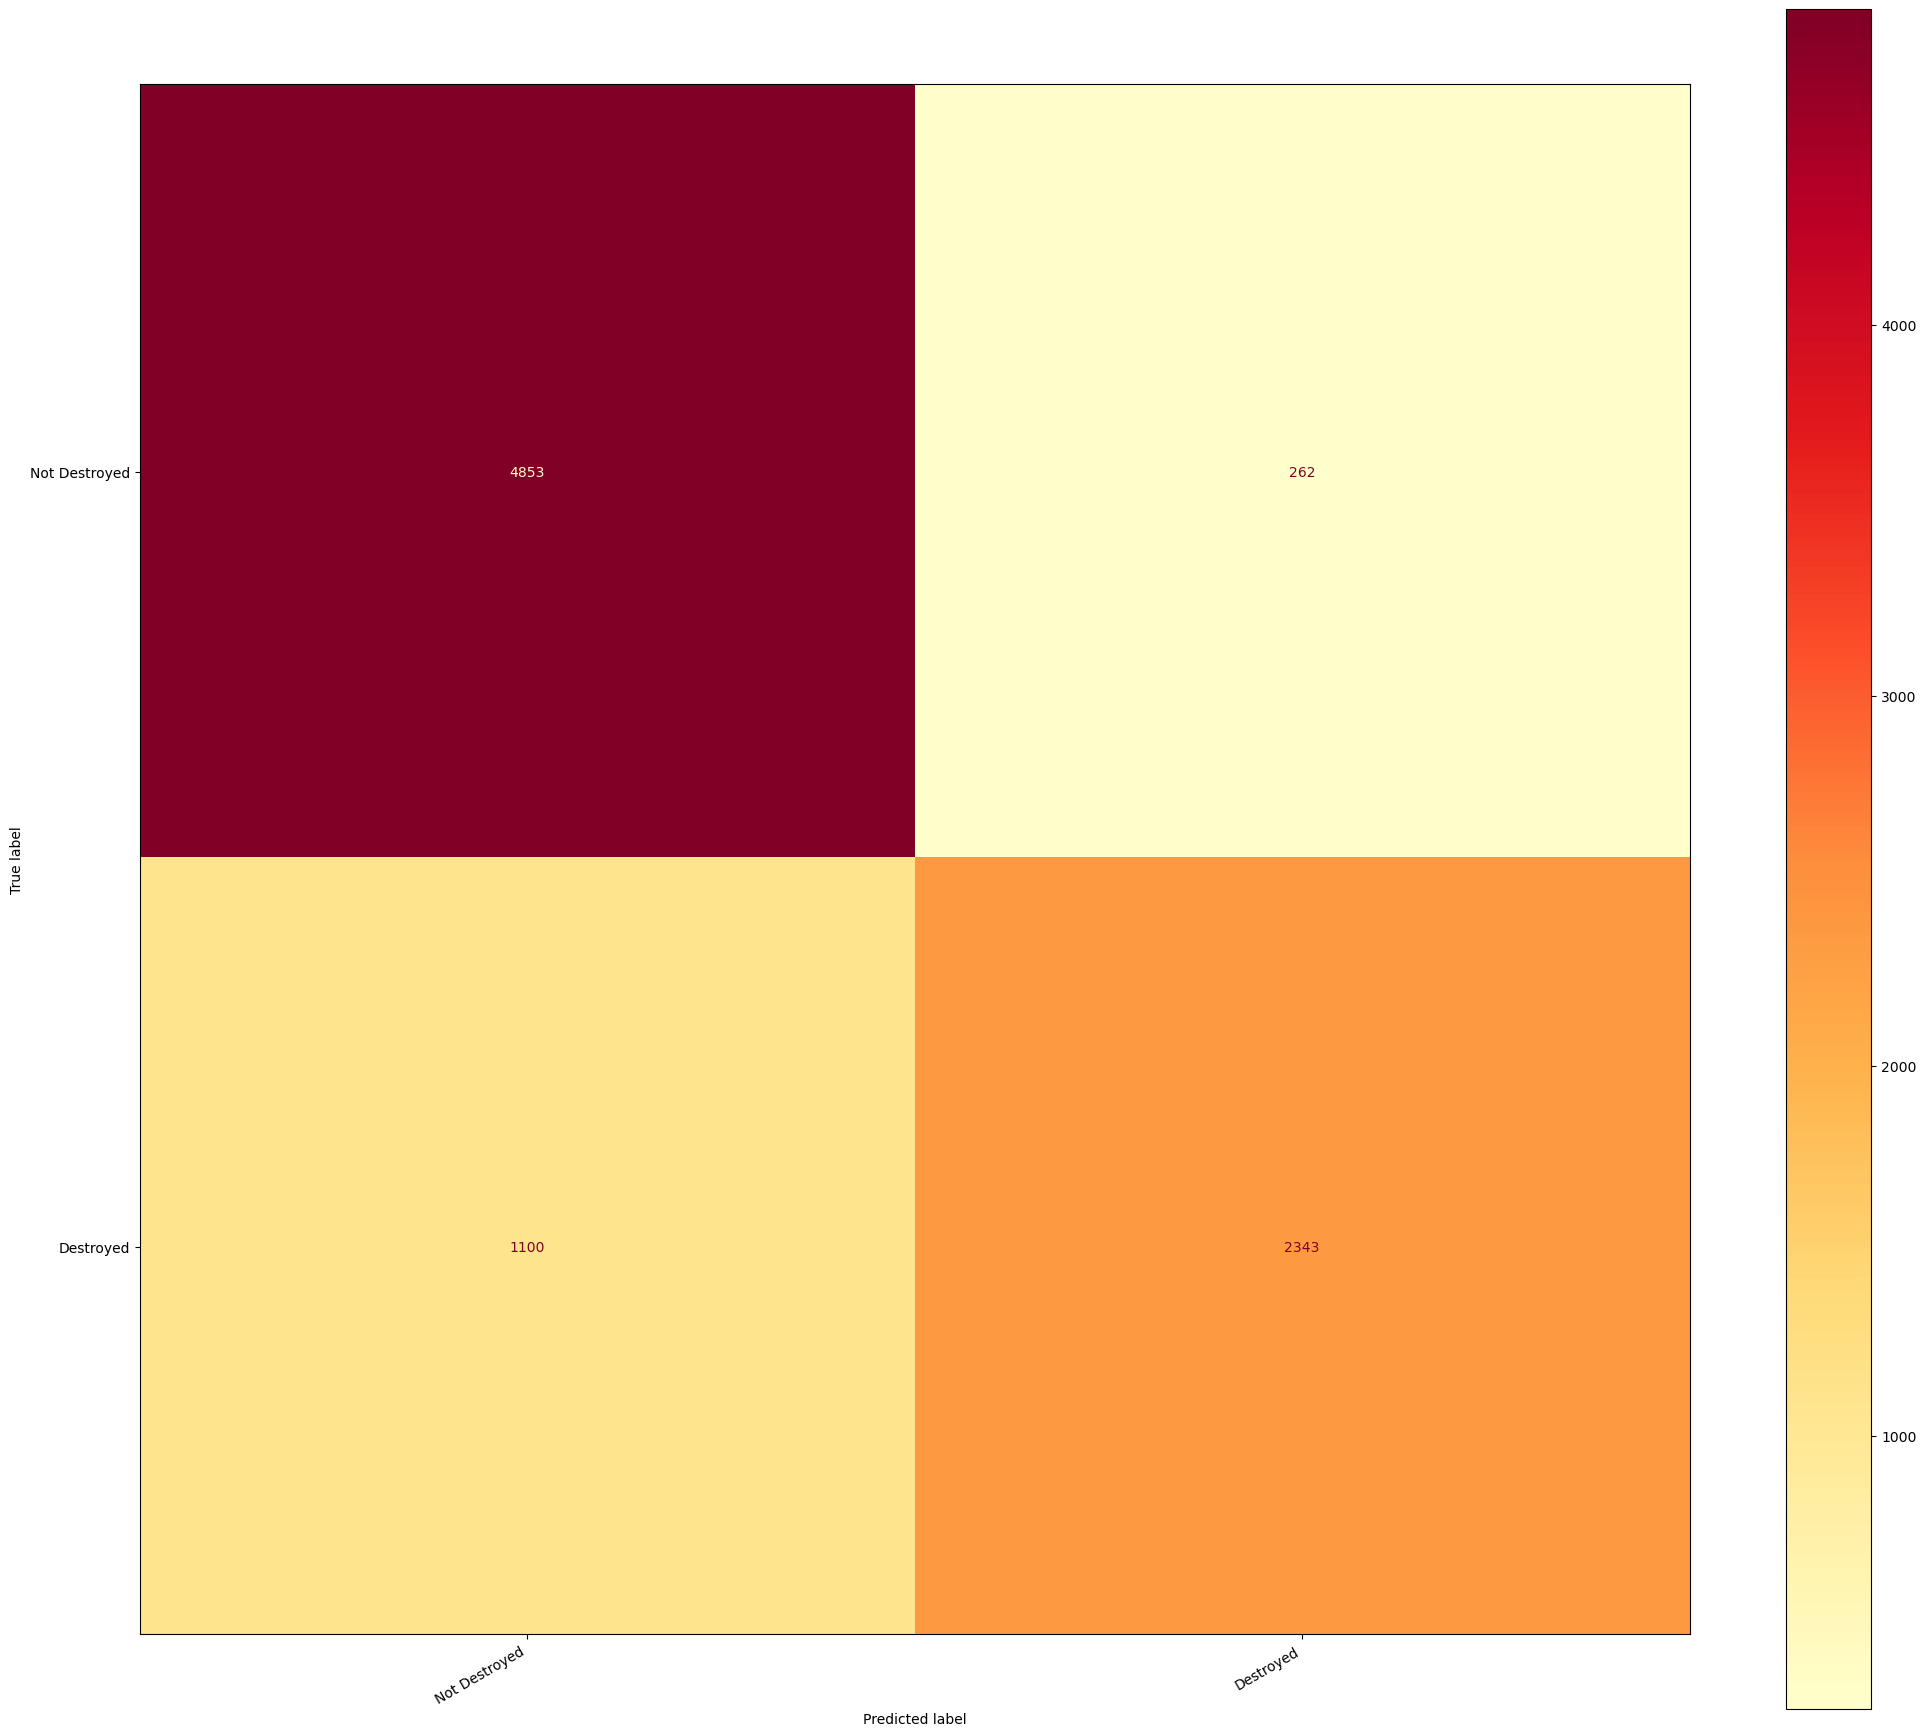

In [96]:
cm = confusion_matrix(fire_test.Destroyed, lr.predict(fire_test[features]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(25, 25))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.show()
